# Introduction

This ipynb file is served to collect three pieces of data for Data Wrangling project in Udacity Data Analytics Nanodegree.

The three pieces of data are:
- The WeRateDogs Twitter archive
- The tweet image predictions
- Each tweet's retweet count and favorite ("like") count
    
The report can be broken down into three parts:
- [Data Collection](#collection)
- [Data Assessment](#assessment)
- [Data Wrangling](#wrangling)

In [332]:
#Load necessary modules:

import pandas as pd
import numpy as np

import tweepy
import json

from datetime import datetime
from bs4 import BeautifulSoup as soup
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook

<a id = "collection"></a>
# Data Collection 

In [2]:
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
pred = pd.read_csv('image-predictions.tsv', sep = '\t')

Get Data from Tweepy

In [5]:
# set up and authorize the account 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [9]:
# get the tweets we wrant to scrape
tweet_ids = archive.tweet_id.to_list()

In [7]:
def get_json_file(tweet):
    tweet = api.get_status(tweet)
    tweet_json = json.dumps(tweet._json)
    with open('tweet_json.txt', 'a', encoding = 'utf-8') as f:
        json.dump(tweet_json, f)

In [10]:
for tweet in notebook.tqdm(tweet_ids):
    try:
        get_json_file(tweet)
        with open('tweet_json.txt', 'a', encoding = 'utf-8') as f:
            f.write('\n')
    except: 
        continue

In [12]:
tweet_id = []
retweet = []
like = []

with open('tweet_json.txt') as json_file:
    for data in notebook.tqdm(json_file):
        load_data = json.loads(json.loads(data))
        tweet_id.append(load_data['id'])
        retweet.append(load_data['retweet_count'])
        like.append(load_data['favorite_count'])

In [13]:
tweet_info = {'tweet_id': tweet_id,
             'retweet_count': retweet,
             'like_count': like}
tweet_info = pd.DataFrame(tweet_info)

<a id = "assessment"></a>
# Data Assessment


## The WeRateDogs Twitter archive

In [14]:
archive.head()
# Investigate the dataset visually

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
archive.info()
# check the NA and type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [110]:
sum(archive.tweet_id.duplicated())
# no duplication

0

Rating columns

In [13]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [12]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

The `rating_denominator` column contains denominators that are not 10 as well as huge `rating_numerator`s that are too far beyond the denominator

Text Column

In [125]:
for text in (archive.text.sample(5)):
    print(text)

Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq
This is Sandy. He's sexually confused. Thinks he's a pigeon. Also an All-American cheese catcher. 10/10 so petable https://t.co/Htu8plSqEu
Everybody needs to read this. Jack is our first 14/10. Truly heroic pupper https://t.co/3m6bNGXWnM
Meet Fynn &amp; Taco. Fynn is an all-powerful leaf lord and Taco is in the wrong place at the wrong time. 11/10 &amp; 10/10 https://t.co/MuqHPvtL8c
Meet Tupawc. He's actually a Christian rapper. Doesn't even understand the concept of dollar signs. 10/10 great guy https://t.co/mCqgtqLDCW


Expanded URL column

In [20]:
for x in archive.expanded_urls.sample(10):
    print(x)

https://twitter.com/dog_rates/status/712809025985978368/photo/1,https://twitter.com/dog_rates/status/712809025985978368/photo/1
https://twitter.com/dog_rates/status/776088319444877312/photo/1,https://twitter.com/dog_rates/status/776088319444877312/photo/1,https://twitter.com/dog_rates/status/776088319444877312/photo/1,https://twitter.com/dog_rates/status/776088319444877312/photo/1
https://twitter.com/dog_rates/status/839990271299457024/photo/1,https://twitter.com/dog_rates/status/839990271299457024/photo/1
https://twitter.com/dog_rates/status/711743778164514816/photo/1
https://twitter.com/dog_rates/status/780601303617732608/photo/1,https://twitter.com/dog_rates/status/780601303617732608/photo/1
https://twitter.com/dog_rates/status/672877615439593473/photo/1
https://twitter.com/dog_rates/status/717421804990701568/photo/1,https://twitter.com/dog_rates/status/717421804990701568/photo/1
https://twitter.com/dog_rates/status/668645506898350081/photo/1
https://twitter.com/dog_rates/status/765

In [252]:
sum(archive.expanded_urls.duplicated())

137

If a Twitter contains multiole photos, the expanded link for the second or following photos are wrong. 

There are duplicated in dog photos.

## Image Prediction Data

In [106]:
pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [105]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [109]:
sum(pred.tweet_id.duplicated())
# no duplication

0

In [287]:
sum(pred.jpg_url.duplicated())

66

In [290]:
pred.p1.value_counts()
# lowercase and upper case are mixed

golden_retriever       150
Labrador_retriever     100
Pembroke                89
Chihuahua               83
pug                     57
                      ... 
limousine                1
walking_stick            1
candle                   1
African_hunting_dog      1
conch                    1
Name: p1, Length: 378, dtype: int64

## The Retweet and Like Data

In [15]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 3 columns):
tweet_id         876 non-null int64
retweet_count    876 non-null int64
like_count       876 non-null int64
dtypes: int64(3)
memory usage: 20.7 KB


## Quality Issues
__Archive Data__
1. Thousands of null values in columns of `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`;
2. The last 5 columns contains strings of 'None', `name` column contain 'a's as name;
3. The values of `source` column contain extra tag information of scraped links (i.e. <a href = ...);
4. The `rating_denominator` column contains denominators that are not 10;
5. The `rating_numerator` column contains values that are way larger than the denominator;
6. The text columns contain URLs;
7. Duplicates in `expanded_urls` column;
__Prediction Data__
8. Duplicats in  `jpg_url` column;
9. Lowercase and uppercase spelling are mixed in predictions.
                                                                                         
                                                                               

## Tidiness Issues
__Archive Data__
1. The retweet and in-reply statement shouldn't be in the same table with the dog information;
#2. The last 4 columns represent 4 values for a variable indicating the dog's age.

<a id = "wrangling"></a>
# Data Wrangling


1. (Quality 2) Change the 'None' in last 5 columns to Nones, change the 'a's in `name` column to None as well.


In [28]:
def transfer_to_None(x):
    if (x == 'a') or (x == 'None'):
        return None
    else:
        return x

In [30]:
archive_clean = archive.copy()

In [32]:
last5column = ['name','doggo','floofer','pupper','puppo']
for col in last5column:
    archive_clean[col] = archive[col].apply(transfer_to_None)

2. (Tidiness 2) Make the last 4 columns into 1 column.

In [196]:
def return_growth_period(x):
    tmp_list = [x['doggo'].values[0],\
            x['floofer'].values[0],\
            x['pupper'].values[0],\
            x['puppo'].values[0]]
    if pd.Series(tmp_list).any():
        age = pd.Series(tmp_list).any()
        return age
    else:
        return None

In [201]:
growth_period = []
for idx in range(len(archive_clean)):
    x = archive_clean[idx:idx+1]
    growth_period.append(return_growth_period(x))

In [208]:
archive_clean = pd.concat([archive_clean, pd.DataFrame(growth_period, columns = ['growth_period'])], axis = 1)

In [211]:
archive_clean.growth_period.unique()

array([None, 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [215]:
archive_clean = archive_clean.drop(['doggo', 'puppo', 'pupper', 'floofer'], axis = 1)

In [216]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1556 non-null object
growth_period                 380 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 257.8+ KB


3. (Quality 3) Clean the `source` column.

In [262]:
archive_clean['source'] = archive_clean.source.apply(lambda x: soup(x).text)

4. Filter out rows where the `rating_denominator` value are not 10;

In [268]:
archive_clean = archive_clean.loc[archive_clean['rating_denominator'] == 10, :]

5. Filter our rows where the `rating_numerator` value are too large (set the bar at > 15)

In [269]:
archive_clean.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,    0,   75,    7,    9,    8,    1,   27,    3,    4, 1776,
         26,    2], dtype=int64)

In [270]:
archive_clean = archive_clean.loc[archive_clean['rating_numerator'] <= 15, :]

6. Drop the URLs in The text columns;

In [278]:
def clean_URL(text):
    return re.sub(' https://.*', '', text)

In [281]:
archive_clean['text'] = archive_clean['text'].apply(clean_URL)

7. Drop duplicates in `expanded_urls` column;

In [286]:
archive_clean = archive_clean.drop_duplicates('expanded_urls')

8. Drop duplicats in  `jpg_url` column (Pred dataset);


In [291]:
pred_clean = pred.drop_duplicates('jpg_url')

9. For simplexity and future analysis, unify lowercase for name of dogs in predictions.

In [296]:
pred_clean['p1'] = pred_clean['p1'].str.lower()
pred_clean['p2'] = pred_clean['p2'].str.lower()
pred_clean['p3'] = pred_clean['p3'].str.lower()

c:\users\willa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\willa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\willa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [298]:
pred_clean[['p1', 'p2', 'p3']]

,p1,p2,p3
0,welsh_springer_spaniel,collie,shetland_sheepdog
1,redbone,miniature_pinscher,rhodesian_ridgeback
2,german_shepherd,malinois,bloodhound
3,rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,rottweiler,doberman
...,...,...,...
2070,basset,english_springer,german_short-haired_pointer
2071,paper_towel,labrador_retriever,spatula
2072,chihuahua,malamute,kelpie
2073,chihuahua,pekinese,papillon


In [320]:
pred_clean.to_csv('pred_clean.csv')

10. Divide the archive data to two tables: 1) Tweet Information, 2) Dog Description and Ratings.

At the same time, drop unnecessary columns that contain too many emptiness.

In [313]:
tweet_statement = archive_clean[['tweet_id', 'timestamp', 'source']]

In [314]:
tweet_statement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2196 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id     2196 non-null int64
timestamp    2196 non-null object
source       2196 non-null object
dtypes: int64(1), object(2)
memory usage: 68.6+ KB


Furthermore, `tweet_statement` should join with `tweet_info`, since these two have the same obervational unit of tweets' information.

In [315]:
twitter_archive_master = pd.merge(tweet_statement, tweet_info, on = 'tweet_id')

In [317]:
twitter_archive_master.info()
# Since a lot of data are lost from API, the cleaned dataframe is much smaller than original.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 0 to 791
Data columns (total 5 columns):
tweet_id         792 non-null int64
timestamp        792 non-null object
source           792 non-null object
retweet_count    792 non-null int64
like_count       792 non-null int64
dtypes: int64(3), object(2)
memory usage: 37.1+ KB


In [318]:
# save to file
twitter_archive_master.to_csv('twitter_archive_master.csv')

In [305]:
dog_rating = archive_clean[['tweet_id', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'growth_period']]

In [306]:
dog_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2196 entries, 0 to 2355
Data columns (total 7 columns):
tweet_id              2196 non-null int64
text                  2196 non-null object
expanded_urls         2195 non-null object
rating_numerator      2196 non-null int64
rating_denominator    2196 non-null int64
name                  1487 non-null object
growth_period         355 non-null object
dtypes: int64(3), object(4)
memory usage: 137.2+ KB


Since we cannot fill the `name` and `growth_period`, we can only leave them there.

In [319]:
dog_rating.to_csv('dog_rating.csv')

# Conclusion of Data Wrangling

During the process of data wrangling, I majorly looked into data quality and tidiness issues in the three files: 
- The WeRateDogs Twitter archive
- The tweet image predictions
- Each tweet's retweet count and favorite ("like") count

After wrangling, I saved these data into three files, they are:
- twitter_archive_master: storing information about each tweet itself;
- dog-rating: storing description and ratings about each dog; 
- pred: storing predictions made on the dog-ratings.


# Analyzing and Visualizing the Data

Set the major questions:
- What growth period of dogs had occurred in the ratings most? And what are their average ratings?
- Is putting more images in tweets correlated with higher rating scores?
- Are the retweets and likes the tweet get correlated to dog ratings?

## What growth period of dogs had occurred in the ratings most? And what are their average ratings?

In [322]:
dog_rating.growth_period.value_counts()

pupper     231
doggo       90
puppo       25
floofer      9
Name: growth_period, dtype: int64

In [328]:
dog_rating.groupby('growth_period')['rating_numerator'].agg('mean')

growth_period
doggo      11.833333
floofer    11.888889
pupper     10.792208
puppo      12.000000
Name: rating_numerator, dtype: float64

Text(0.5, 0, 'Score out of 10')

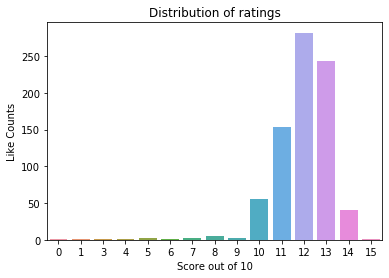

In [365]:
sns.countplot(x='rating_numerator', data=df2)
plt.title('Distribution of ratings')
plt.ylabel('Like Counts')
plt.xlabel('Score out of 10')

In [368]:
dog_rating.rating_numerator.median()

11.0

Conclusion: From the data we have, puppers appear most frequently on WeRateDogs -- At least people tend to remember the term of 'pupper' and are willing to use that in tweets. However, they have a lowest average score of rating among all the growth-periods -- even lower than the median of all the ratings.

## Is putting more images in tweets correlated with higher rating scores?

In [330]:
df = pd.merge(pred, dog_rating, on = 'tweet_id')

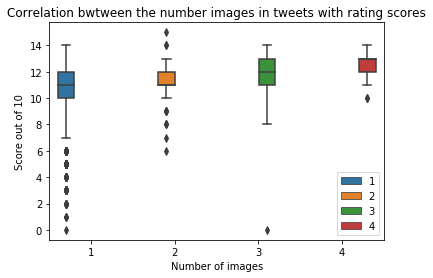

In [350]:
sns.boxplot(x='img_num', y='rating_numerator', hue = 'img_num', data=df)
plt.title('Correlation bwtween the number images in tweets with rating scores')
plt.ylabel('Score out of 10')
plt.xlabel('Number of images')
plt.legend(loc='best')

Conclusion: The boxplot shows a subtle positive correlation bwtween the number images in tweets with rating scores. So if a user want to have his/her dog rated higher, he/she could try upload more imgs for it.

## Are the retweets and likes a tweet get correlated to dog ratings?

In [338]:
df2 = pd.merge(twitter_archive_master, dog_rating, on = 'tweet_id')

Text(0.5, 6.79999999999999, 'Score out of 10')

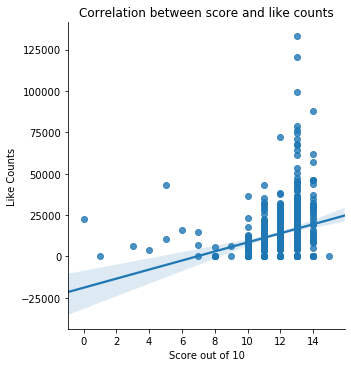

In [362]:
sns.lmplot(x='rating_numerator', y='like_count',data=df2)
plt.title('Correlation between score and like counts')
plt.ylabel('Like Counts')
plt.xlabel('Score out of 10')

Text(0.5, 6.79999999999999, 'Score out of 10')

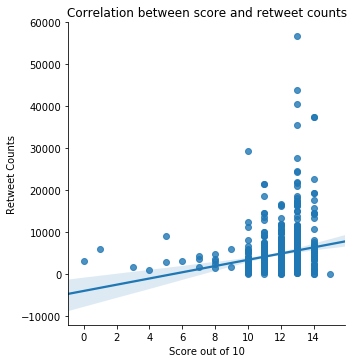

In [363]:
sns.lmplot(x='rating_numerator', y='retweet_count',data=df2)
plt.title('Correlation between score and retweet counts')
plt.ylabel('Retweet Counts')
plt.xlabel('Score out of 10')

Conclusion: The scope of linear regression line suggests that there is a positive correlation between the number of retweets and likes a tweet get correlated to dog ratings. But when ratings are severly low, which is a rare case, the number of retweets and likes a tweet get will also be slightly larger.

# Conclusion of Data Analysis

During the session of data analytics, I found three key insights:
1. Puppers appear most frequently on WeRateDogs -- At least people tend to remember the term of 'pupper' and are willing to use that in tweets. However, puppers have a lowest average score of rating among all the growth-periods.
2. There's a positive correlation between the number images in tweets with rating scores. So if a user want to have his/her dog rated higher, he/she could try upload more imgs for it.
3. There's a positive correlation between the number of retweets and likes a tweet get correlated to dog ratings. But when ratings are severly low, which is a rare case, the number of retweets and likes a tweet get will also be slightly larger.